In [8]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# All the dependencies you need, can be installed by running .
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
#nltk.download('reuters')
from nltk.corpus import reuters

In [9]:
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

In [35]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [36]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

## Question 1.1: Implement distinct_words
Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with for loops, but it's more efficient to do it with Python list comprehensions. In particular, this may be useful to flatten a list of lists. 

You may find it useful to use Python sets to remove duplicate words.

In [12]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    corpus = [w for w_list in corpus for w in w_list]
    #sorted:默认情况下，对字符串排序，是按照ASCII的大小比较的，由于'Z' < 'a'，大写字母Z会排在小写字母a的前面。
    corpus_words = sorted(list(set(corpus)))
    num_corpus_words = len(corpus_words)

    # ------------------

    return corpus_words, num_corpus_words

In [38]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["START", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "END"])))
#顺序['All', "All's", 'END', 'START', 'ends', 'glitters', 'gold', "isn't", 'that', 'well']
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Question 1.2: Implement compute_co_occurrence_matrix
Write a method that constructs a co-occurrence matrix for a certain window-size  n  (with a default of 4), considering words  n  before and  n  after the word in the center of the window. Here, we start to use numpy (np) to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n Python NumPy tutorial.

In [13]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # ------------------
    # Write your implementation here.
    M = np.zeros([num_words, num_words])
    word2Ind = dict(zip(words, range(num_words)))
    for doc in corpus:
        current_idx = 0
        doc_len = len(doc)
        while current_idx < doc_len:
            left = max(current_idx - window_size, 0)
            right = min(current_idx + window_size + 1,doc_len)
            #列表索引的最右端索引数字不包含例list2 = [1, 2, 3, 4, 5, 6, 7 ]   list2[1:5]:  [2, 3, 4, 5]
            outside_words = doc[left : current_idx] + doc[current_idx + 1 : right]
            center_word = doc[current_idx]
            center_idx = word2Ind[center_word]
            
            for outside_word in outside_words:
                outside_idx = word2Ind[outside_word]
                M[outside_idx, center_idx] += 1
            current_idx +=1

    # ------------------

    return M, word2Ind

In [40]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,],
     [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,],
     [0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,]]
)
word2Ind_ans = {'All': 0, "All's": 1, 'END': 2, 'START': 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Question 1.3: Implement reduce_to_k_dim
Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

Note: All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use sklearn.decomposition.TruncatedSVD.

In [14]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M) # Fit LSI model to X and perform dimensionality reduction on X.
        # ------------------

    print("Done.")
    return M_reduced

In [42]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Question 1.4: Implement plot_embeddings
Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (plt).

For this example, you may find it useful to adapt this code. In the future, a good way to make a plot is to look at the Matplotlib gallery, find a plot that looks somewhat like what you want, and adapt the code they give.

In [15]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for word in words:
        idx = word2Ind[word]
        embedding = M_reduced[idx]
        x = embedding[0]
        y = embedding[1]
        
        plt.scatter(x,y,marker='x', color='red')
        plt.text(x, y, word, fontsize=9)

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


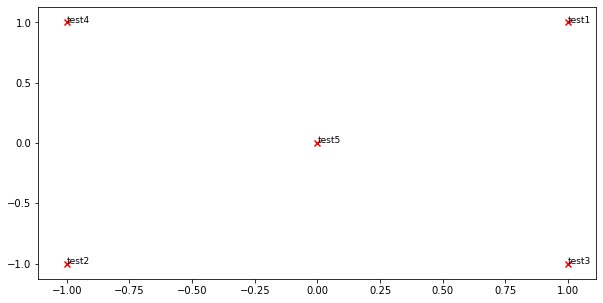

In [44]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

## Question 1.5: Co-Occurrence Plot Analysis
Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4, over the Reuters "crude" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U*S, so we normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). Note: The line of code below that does the normalizing uses the NumPy concept of broadcasting. If you don't know about broadcasting, check out Computation on Arrays: Broadcasting by Jake VanderPlas.

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? Note: "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


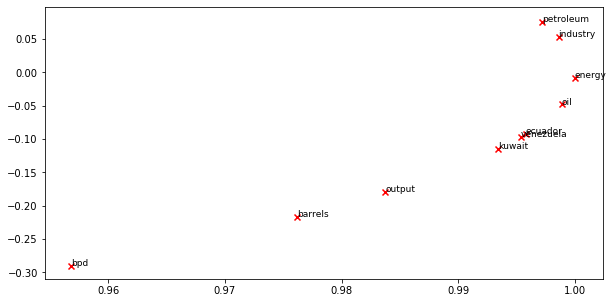

In [45]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

## Part 2: Prediction-Based Word Vectors
As discussed in class, more recently prediction-based word vectors have come into fashion, e.g. word2vec. Here, we shall explore the embeddings produced by word2vec. Please revisit the class notes and lecture slides for more details on the word2vec algorithm. If you're feeling adventurous, challenge yourself and try reading the original paper.

Then run the following cells to load the word2vec vectors into memory. Note: This might take several minutes.

In [4]:
from gensim.models import KeyedVectors
""" Load Word2Vec Vectors
    Return:
        wv_from_bin: All 3 million embeddings, each lengh 300
"""
path = "C:\\Users\\Winnie Xu\\gensim-data\\word2vec-google-news-300\\GoogleNews-vectors-negative300.bin"

wv_from_bin = KeyedVectors.load_word2vec_format(path, binary=True)


### Reducing dimensionality of Word2Vec Word Embeddings
Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

Put the 3 million word2vec vectors into a matrix M
Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 300-dimensional to 2-dimensional.

In [11]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [16]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


## Question 2.1: Word2Vec Plot Analysis [written] (4 points)
Run the cell below to plot the 2D word2vec embeddings for ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela'].

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

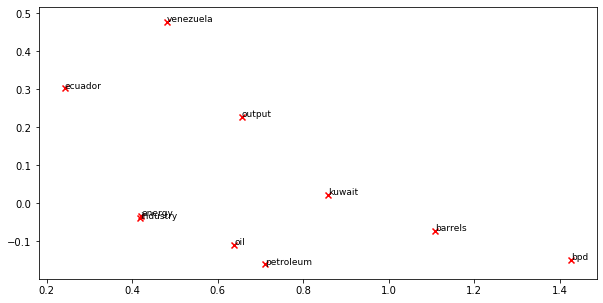

In [17]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

## Question 2.2: Polysemous Words (2 points) [code + written]
Find a polysemous word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from both meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

Note: You should use the wv_from_bin.most_similar(word) function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the GenSim documentation.

In [30]:
# ------------------
# Write your polysemous word exploration code here.

wv_from_bin.most_similar("close")

# ------------------

[('closed', 0.580970823764801),
 ('closing', 0.547910213470459),
 ('closest', 0.5217792987823486),
 ('closer', 0.5146691799163818),
 ('toclose', 0.5086751580238342),
 ('Close', 0.4905688762664795),
 ('open', 0.463651180267334),
 ('closes', 0.44070184230804443),
 ('between', 0.4379839301109314),
 ('nearer', 0.4120941758155823)]

#### 一个多义词里有不同含义的单词
Find a polysemous word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from both meanings.<br />
"leaves":arrives到达, stalks秸秆 <br />
"attend":enroll注册, partake参加 <br />
"close":open打开,between之间

## Question 2.3: Synonyms & Antonyms 
When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful".

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the wv_from_bin.distance(w1, w2) function here in order to compute the cosine distance between two words. Please see the GenSim documentation for further assistance.

In [32]:
# ------------------
# Write your synonym & antonym exploration code here.

w1 = "happy"
w2 = "cheerful"
w3 = "unhappy"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

# ------------------


Synonyms happy, cheerful have cosine distance: 0.6162261664867401
Antonyms happy, unhappy have cosine distance: 0.3871961832046509


#### give a possible explanation for why this counter-intuitive result may have happened.
Synonyms happy, cheerful have cosine distance: 0.6162261664867401<br />
Antonyms happy, sad have cosine distance: 0.46453857421875<br />
Synonyms happy, cheerful have cosine distance: 0.6162261664867401<br />
Antonyms happy, unhappy have cosine distance: 0.3871961832046509<br />

### Solving Analogies with Word Vectors
Word2Vec vectors have been shown to sometimes exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : x", what is x?

In the cell below, we show you how to use word vectors to find x. The most_similar function finds words that are most similar to the words in the positive list and most dissimilar from the words in the negative list. The answer to the analogy will be the word ranked most similar (largest numerical value).

Note: Further Documentation on the most_similar function can be found within the GenSim documentation.

In [33]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]


## Question 2.4: Finding Analogies [code + written] (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

Note: You may have to try many analogies to find one that works!

In [38]:
# ------------------
# Write your analogy exploration code here.
# sky:plane :: sea:
pprint.pprint(wv_from_bin.most_similar(positive=['sea', 'plane'], negative=['sky']))

# ------------------

[('freighter', 0.5288207530975342),
 ('boat', 0.5190157294273376),
 ('vessel', 0.5146465301513672),
 ('airplane', 0.5120129585266113),
 ('ship', 0.5039366483688354),
 ('jetliner', 0.5030276775360107),
 ('Alvei', 0.5003480315208435),
 ('fishing_boat', 0.49840664863586426),
 ('fishing_trawler', 0.49425503611564636),
 ('HMS_Gloucester', 0.48404163122177124)]


## Question 2.5: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does not hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [39]:
# ------------------
# Write your incorrect analogy exploration code here.
# tree : leaf :: flower : petal
pprint.pprint(wv_from_bin.most_similar(positive=['flower', 'leaf'], negative=['tree']))

# ------------------

[('floral', 0.5532568693161011),
 ('marigold', 0.5291938185691833),
 ('tulip', 0.5213128924369812),
 ('rooted_cuttings', 0.5189826488494873),
 ('variegation', 0.5136324167251587),
 ('Asiatic_lilies', 0.5132641792297363),
 ('gerberas', 0.5106234550476074),
 ('gerbera_daisies', 0.5101010799407959),
 ('Verbena_bonariensis', 0.5070016980171204),
 ('violet', 0.5058107972145081)]


## Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)
It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit to our word embeddings.

Run the cell below, to examine (a) which terms are most similar to "woman" and "boss" and most dissimilar to "man", and (b) which terms are most similar to "man" and "boss" and most dissimilar to "woman". What do you find in the top 10?

In [34]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'boss'], negative=['woman']))

[('bosses', 0.5522644519805908),
 ('manageress', 0.49151360988616943),
 ('exec', 0.459408164024353),
 ('Manageress', 0.45598435401916504),
 ('receptionist', 0.4474116861820221),
 ('Jane_Danson', 0.44480547308921814),
 ('Fiz_Jennie_McAlpine', 0.44275766611099243),
 ('Coronation_Street_actress', 0.44275569915771484),
 ('supremo', 0.4409852921962738),
 ('coworker', 0.4398624897003174)]

[('supremo', 0.6097397804260254),
 ('MOTHERWELL_boss', 0.5489562153816223),
 ('CARETAKER_boss', 0.5375303626060486),
 ('Bully_Wee_boss', 0.5333974361419678),
 ('YEOVIL_Town_boss', 0.5321705341339111),
 ('head_honcho', 0.5281980037689209),
 ('manager_Stan_Ternent', 0.525971531867981),
 ('Viv_Busby', 0.5256163477897644),
 ('striker_Gabby_Agbonlahor', 0.5250812768936157),
 ('BARNSLEY_boss', 0.5238943099975586)]


## Question 2.7: Independent Analysis of Bias in Word Vectors [code + written] (2 points)
Use the most_similar function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [46]:
# ------------------
# Write your bias exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['African','rich'], negative=['European']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['European', 'rich'], negative=['African']))

# ------------------

[('Melamine_nitrogen', 0.47855693101882935),
 ('wealthy', 0.45455461740493774),
 ('poverty_stricken', 0.44563359022140503),
 ('impoverished', 0.43277615308761597),
 ('friend_Francie_Vos', 0.4242717921733856),
 ('richer', 0.4191373586654663),
 ('Africas', 0.4085571765899658),
 ('Royal_Bafokeng_Nation', 0.4074103832244873),
 ('fabulously_rich', 0.40641364455223083),
 ('nomadic_Tuareg', 0.4061325192451477)]

[('Europe', 0.4173327684402466),
 ('richer', 0.41097572445869446),
 ('EU', 0.39631912112236023),
 ('Scicasts_Resource_Library', 0.3850439786911011),
 ('European_Union', 0.3770194351673126),
 ('Autonomy_Virage_visionary', 0.3756405711174011),
 ('Finland_Latvia_Lithuania', 0.37100017070770264),
 ('Hunton_liquids', 0.36862069368362427),
 ('Europen', 0.3667074143886566),
 ('Demján', 0.3666282892227173)]


man:engineer :: woman差别不大<br />
man:doctor :: woman有偏见<br />
man:teacher :: woman有偏见<br />
African:rich :: European有偏见

## Question 2.8: Thinking About Bias [written] (1 point)
What might be the cause of these biases in the word vectors?<br />
偏见来自于语料库